In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import beta
import re
from scipy.optimize import minimize

/Users/zsr/opt/anaconda3/envs/GR5206/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# The following is a simple example of how to use the ELBO function basing on https://rstudio-pubs-static.s3.amazonaws.com/630126_c2063706da044eb6a2944d7027dcce4d.html
# There is open source code for the ELBO function using python at https://pyro.ai/examples/svi_part_i.html

In [13]:
"""
x is a vector of observed data
z is a vector of latent variables
returns the log likelihood of the data given the latent variables
in this case, the log likelihood is the log probability mass function of a binomial distribution
The pruned binomial distribution is used to avoid numerical issues with the log likelihood
"""

def log_likelihood(x,z):

    val = binom.logpmf(np.repeat(x,z.shape[0]), 1, np.tile(z, x.shape[0]))
    val[np.isinf(val) & (val < 0)] = -10000
    val[np.isinf(val) & (val > 0)] = 10000
    return val

In [22]:
"""z is a vector of latent variables
returns the log prior of the latent variables
in this case, the log prior is the log probability density function of a beta distribution
The pruned beta distribution is used to avoid numerical issues
The initial values of the beta distribution are set to 10,10"""

def log_prior(z):

    val = beta.logpdf(z, a=10, b=10)
    val[np.isinf(val) & (val < 0)] = -10000
    val[np.isinf(val) & (val > 0)] = 10000
    return val

In [15]:
"""z is a vector of latent variables
phi is a vector of variational parameters
returns the log variational distribution of the latent variables
in this case, the log variational distribution is the log probability density function of a beta distribution
The pruned beta distribution is used to avoid numerical issues"""
def log_variational(z, phi):

    val = beta.logpdf(z, a=phi[0], b=phi[1])
    val[np.isinf(val) & (val < 0)] = -10000
    val[np.isinf(val) & (val > 0)] = 10000
    return val

In [16]:
"""phi is a vector of variational parameters
x is a vector of observed data
n_samples is the number of samples used to approximate the expectation
returns the simulated ELBO value
I changed the function to use the same seed for the random number generator to make the results reproducible
Also, I vectorized the code to make it faster"""


def ELBO(phi, x, n_samples=10000):

    np.random.seed(20230125)
    sum = 0
    # simulates z
    z = beta.rvs(a=phi[0], b=phi[1], size=n_samples)

    # sum of log likelihoods
    sum_log_lik = np.sum(log_likelihood(x, z))

    # log prior
    log_pr = np.sum(log_prior(z))

    # log variational
    log_var = np.sum(log_variational(z, phi))
    sum += sum_log_lik + log_pr - log_var

    # average (approximates expectation)
    return sum / n_samples


"""phi is a vector of variational parameters
x is a vector of observed data
n_samples is the number of samples used to approximate the expectation
returns the negative ELBO value"""

def neg_ELBO(phi, x, n_samples=10000):
    return -ELBO(phi, x, n_samples)

In [30]:
def optim_ELBO(phi0, x_sample, n_samples):
    # fnscale -1 is used for specifying a maximization problem
    bounds = [(0.00001, 1000), (0.00001, 1000)]
    result = minimize(neg_ELBO, phi0, args=(x_sample, n_samples), bounds=bounds, method='L-BFGS-B')
    return result

In [31]:
def plot_posterior(phi_opt, true_prob, n_tos,plot_ax,x_sample):
    x = np.linspace(0, 1, 100)
    y = beta.pdf(x, a=phi_opt[0], b=phi_opt[1])
    plot_ax.plot(x, y, 'r-', lw=2, label='Posterior Distribution')
    plot_y = beta.pdf(x, a = np.sum(x_sample)+1, b = n_tos - np.sum(x_sample)+1)
    plot_ax.plot(x, plot_y, 'g-', lw=2, label='True Distribution')
    # plot_ax.axvline(true_prob, color='blue', lw=1.6, label='True Probability')
    plot_ax.set_xlabel('z')
    plot_ax.set_ylabel('q(z)')
    plot_ax.set_title(f'With {n_tos} tosses')
    plot_ax.legend()

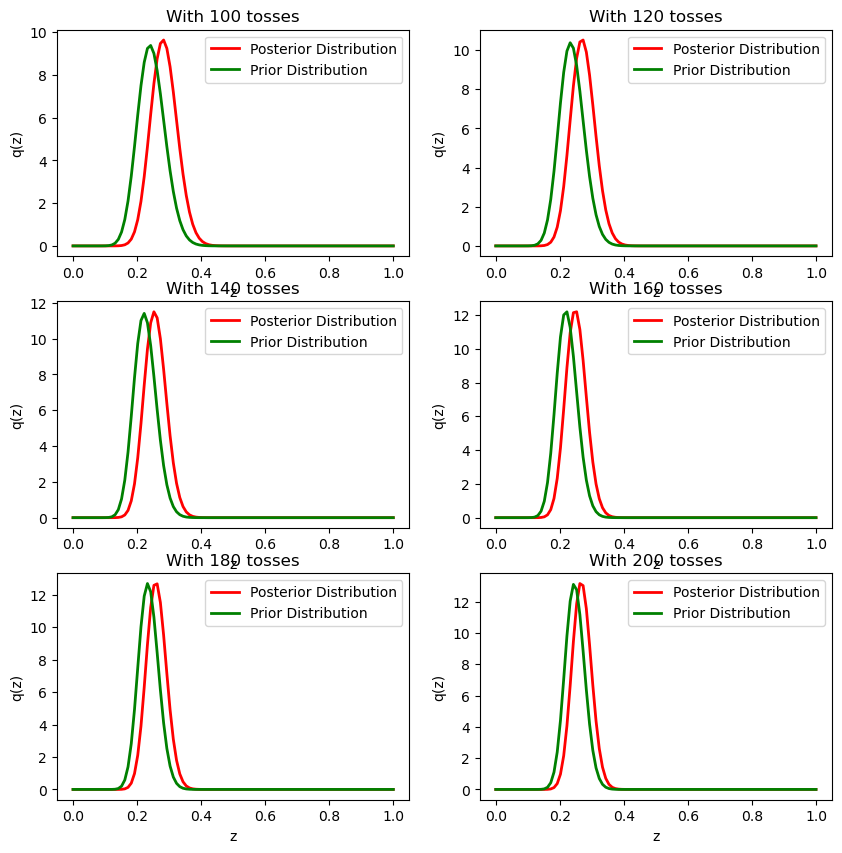

'\nI have tried to use the ELBO function to estimate the posterior distribution of a binomial distribution, but the precision of estimation is limited by the prior function. When the true_prob is close to 0.5 (like 0.6), the overall performance is great.\nBut when the true_prob is close to 0 or 1, the estimation is not good. I think the reason is that the prior function is not good enough to capture the posterior distribution.\n'

In [32]:
#True probability of heads
true_prob = 0.3

#Initial values for alpha and beta
phi0 = [50, 50]

#Number of samples from 
#the variational distribution
n_samples = 2000

#Number of tosses
n_tos = 100

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.ravel()
to_plot = []
for i, ax in zip(range(100, 220, 20), axs):
    x_sample = np.random.binomial(1, true_prob, size=i)

    phi_opt = optim_ELBO(phi0, x_sample, n_samples)

    plot_posterior(phi_opt.x, true_prob, i, ax,x_sample)
plt.show()


"""
I have tried to use the ELBO function to estimate the posterior distribution of a binomial distribution, but the precision of estimation is limited by the prior function. When the true_prob is close to 0.5 (like 0.6), the overall performance is great.
But when the true_prob is close to 0 or 1, the estimation is not good. I think the reason is that the prior function is not good enough to capture the posterior distribution.
"""

In [27]:
[np.sum(x_sample)+1, n_tos - np.sum(x_sample)+1]

[50, 52]

In [33]:
phi_opt.x

array([ 58.54296898, 159.18374372])

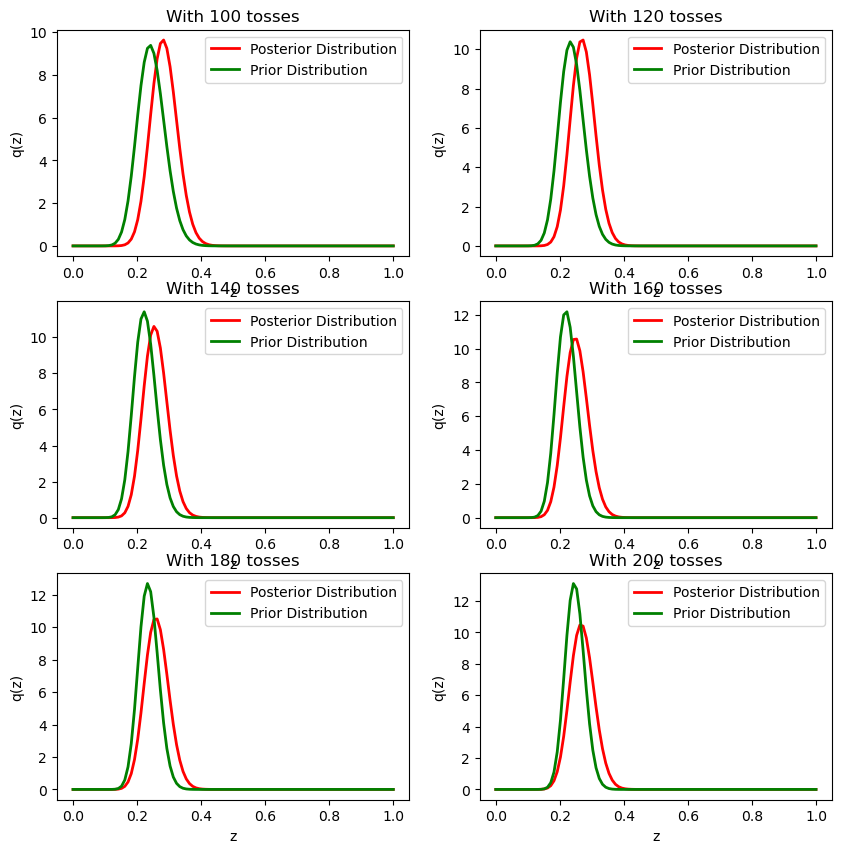

'\nI have tried to use the ELBO function to estimate the posterior distribution of a binomial distribution, but the precision of estimation is limited by the prior function. When the true_prob is close to 0.5 (like 0.6), the overall performance is great.\nBut when the true_prob is close to 0 or 1, the estimation is not good. I think the reason is that the prior function is not good enough to capture the posterior distribution.\n'

In [24]:
#True probability of heads
true_prob = 0.3

#Initial values for alpha and beta
phi0 = [8, 5]

#Number of samples from 
#the variational distribution
n_samples = 2000

#Number of tosses
n_tos = 100

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.ravel()
to_plot = []
for i, ax in zip(range(100, 220, 20), axs):
    x_sample = np.random.binomial(1, true_prob, size=i)

    phi_opt = optim_ELBO(phi0, x_sample, n_samples)
    
    plot_posterior(phi_opt.x, true_prob, i, ax,x_sample)
plt.show()


"""
I have tried to use the ELBO function to estimate the posterior distribution of a binomial distribution, but the precision of estimation is limited by the prior function. When the true_prob is close to 0.5 (like 0.6), the overall performance is great.
But when the true_prob is close to 0 or 1, the estimation is not good. I think the reason is that the prior function is not good enough to capture the posterior distribution.
"""